For analysis competition...
- feaute generation
- adversarial validation
- feature importance
- one hot nan
- pseudolabel
- data augumentation


# Libraries

In [1]:
# basics
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import gc
import json
import time
import datetime
import os

# visualize
import matplotlib.pyplot as plt
import matplotlib.style as style
from matplotlib_venn import venn2
import seaborn as sns
from matplotlib import pyplot
import plotly.figure_factory as ff
import plotly.express as px
import missingno as msno

sns.set_context("talk")
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})
style.use('fivethirtyeight')

# model
from sklearn.preprocessing import LabelEncoder, PowerTransformer, StandardScaler, MinMaxScaler, OneHotEncoder
import xgboost as xgb
from xgboost import XGBClassifier, XGBRegressor
from xgboost import plot_importance
from catboost import CatBoostRegressor, CatBoostClassifier
import lightgbm as lgb
from sklearn import linear_model
from sklearn.neighbors import KNeighborsRegressor

# NN
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.models import Model
from keras.layers import Input, Layer, Dense, Concatenate, Reshape, Dropout, merge, Add, PReLU, BatchNormalization, GaussianNoise
from keras.layers.embeddings import Embedding
from keras import backend as K
from keras.layers import Layer
from keras.callbacks import *
import tensorflow as tf

# stats
from scipy import stats
from sklearn.metrics import cohen_kappa_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold
from sklearn.model_selection import train_test_split
import scipy as sp
from functools import partial
from collections import Counter

pd.set_option('display.max_rows', None)

import warnings
warnings.filterwarnings('ignore')

print("libraries imported")

/opt/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning:

Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.

Using TensorFlow backend.


libraries imported


# Utilities

In [2]:
# reduce memory
def reduce_mem_usage(df):
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.uint8).min and c_max < np.iinfo(np.uint8).max:
                    df[col] = df[col].astype(np.uint8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.uint16).min and c_max < np.iinfo(np.uint16).max:
                    df[col] = df[col].astype(np.uint16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.uint32).min and c_max < np.iinfo(np.uint32).max:
                    df[col] = df[col].astype(np.uint32)                    
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
                elif c_min > np.iinfo(np.uint64).min and c_max < np.iinfo(np.uint64).max:
                    df[col] = df[col].astype(np.uint64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    return df

In [3]:
# column checker
def column_checker(train, test, features):
    # data_type (numerical or categorical), n_nan, n_unique
    chk = pd.DataFrame()
    chk["features"] = features
    columns = ["is_categorical", "overlap","train_nans", "test_nans", "train_nunique", "test_nunique", 
                      "train_min", "test_min", "train_max", "test_max", "train_mean", "test_mean", 
                      "train_skew", "test_skew"]
    for c in columns:
        chk[c] = np.nan
    chk["is_categorical"] = 0
    for i, f in enumerate(features):
        # dtype
        if "id" in f:
            train[f] = train[f].astype(str)
            test[f] = test[f].astype(str)
        if train[f].dtype == "object":
            chk.loc[i, "is_categorical"] = 1
            chk.loc[i, "overlap"] = len(set(train[f].values.tolist() + test[f].values.tolist())) / train[f].nunique()
        else:
            # descriptive stats
            chk.loc[i, "train_min"] = np.nanmin(train[f].values)
            chk.loc[i, "test_min"] = np.nanmin(test[f].values)
            chk.loc[i, "train_mean"] = np.nanmean(train[f].values)
            chk.loc[i, "test_mean"] = np.nanmean(test[f].values)
            chk.loc[i, "train_max"] = np.nanmax(train[f].values)
            chk.loc[i, "test_max"] = np.nanmax(test[f].values)
            chk.loc[i, "train_skew"] = train.loc[train[f].isna().values == False, f].skew()
            chk.loc[i, "test_skew"] = test.loc[test[f].isna().values == False, f].skew()
            
        # nans
        chk.loc[i, "train_nans"] = train[f].isna().sum()
        chk.loc[i, "test_nans"] = test[f].isna().sum()
        
        # nuniques
        chk.loc[i, "train_nunique"] = train[f].nunique()
        chk.loc[i, "test_nunique"] = test[f].nunique()
        
    for c in ["is_categorical", "train_nans", "test_nans", "train_nunique", "test_nunique"]:
        chk[c] = chk[c].astype(int)
    return chk

In [4]:
# Imputer
def nan2onehot(df, features):
    isnan_features = []
    for f in features:
        if df[f].isna().sum() > len(df) * 0.05:
            df[f + "_isnan"] = np.zeros(len(df))
            df.loc[(df[f].isna().values == True), f + "_isnan"] = 1
            isnan_features.append(f + "_isnan")
    return df, isnan_features
        
# outlier remover
def clipper(df, features):
    p01 = df[features].quantile(0.01)
    p99 = df[features].quantile(0.99)
    df[features] = df[features].clip(p01, p99, axis=1)
    return df
    
# to normal dist
def to_normal(df, features, method="yeo-johnson"):
    # method can be box-cox
    pt = PowerTransformer(method=method)
    pt.fit(df[features])
    df[features] = pt.transform(df[features])
    return df

# remove correlated features
def remove_correlated_features(df, features, threshold=0.999):
    counter = 0
    to_remove = []
    for feat_a in features:
        for feat_b in features:
            if feat_a != feat_b and feat_a not in to_remove and feat_b not in to_remove:
                c = np.corrcoef(reduce_train[feat_a], reduce_train[feat_b])[0][1]
                if c > threshold:
                    counter += 1
                    to_remove.append(feat_b)
                    print('{}: FEAT_A: {} FEAT_B: {} - Correlation: {}'.format(counter, feat_a, feat_b, c))
    return to_remove

# sensitivity index
def d_prime(train, test, feature):
    tr = train[feature].values
    ts = test[feature].values
    return (np.nanmean(tr) - np.nanmean(ts)) / np.sqrt(0.5 * (np.nanvar(tr) + np.nanvar(ts)))

## Plot functions

In [5]:
# histogram
def plot_hist(train, test, feature):
    # for a dense feature
    fig, ax = plt.subplots(1, 1, figsize=(8, 5))
    sns.distplot(train[feature], color="k", kde=False, ax=ax)
    sns.distplot(test[feature], color="r", kde=False, ax=ax)
    ax.axvline(np.nanmean(train[feature].values), color="k", label="train")
    ax.axvline(np.nanmean(test[feature].values), color="r", label="test")
    ax.legend(frameon=False)
    ax.set_xlabel(feature)
    
def plot_count(train, test, feature):
    # for a categorical feature
    df = pd.DataFrame()
    df["is_train"] = np.zeros(len(train) + len(test))
    df.loc[:len(train), "is_train"] = 1
    df["is_train"] = df["is_train"].astype(int)
    df[feature] = np.hstack((train[feature].values, test[feature].values))
    sns.catplot(x=feature, col="is_train", kind="count", data=df)

# venn plot
def plot_venn(train, test, feature):
    a = train[feature].values.tolist()
    b = test[feature].values.tolist()
    venn2([set(a), set(b)],
           set_labels = ('train', 'test'))
    plt.title(feature)

# vs target
def plot_vs_target(train, features, target):
    # for dense features
    fig, ax = plt.subplots(np.ceil(len(features) / 5), 5, figsize=(14, 5 * len(features)))
    ax = ax.flatten()
    for i, f in enumerate(features):
        sns.regplot(x=f, y=target, data=train, ax=ax[i])
    plt.tight_layout()

# Load data

In [6]:
!ls

EDA.ipynb  cls_models helpers    inputs     reg_models


In [7]:
# check path
datapath = "inputs/"
files = os.listdir(datapath)
print(files)

['.DS_Store', 'house-prices-advanced-regression-techniques']


In [8]:
# import data
time0 = time.time()

datapath = "inputs/" + files[-1] + "/"
train = pd.read_csv(datapath + 'train.csv')
test = pd.read_csv(datapath + 'test.csv')

time1 = time.time()
print(time1 - time0, " seconds to load data")

0.04498910903930664  seconds to load data


In [9]:
# check train
print(train.shape)
train.head()

(1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [10]:
# check test
print(test.shape)
test.head()

(1459, 80)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


# EDA

## target

In [11]:
# target
target = train.columns.values[~np.isin(train.columns.values, test.columns.values)][0]
print(target)

SalePrice


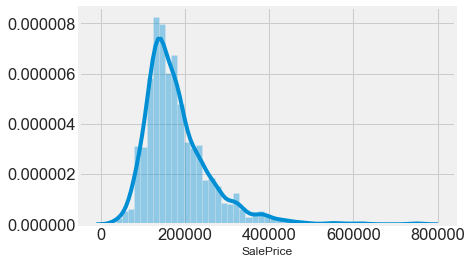

In [12]:
# target histogram
sns.distplot(train[target])

## Missing values

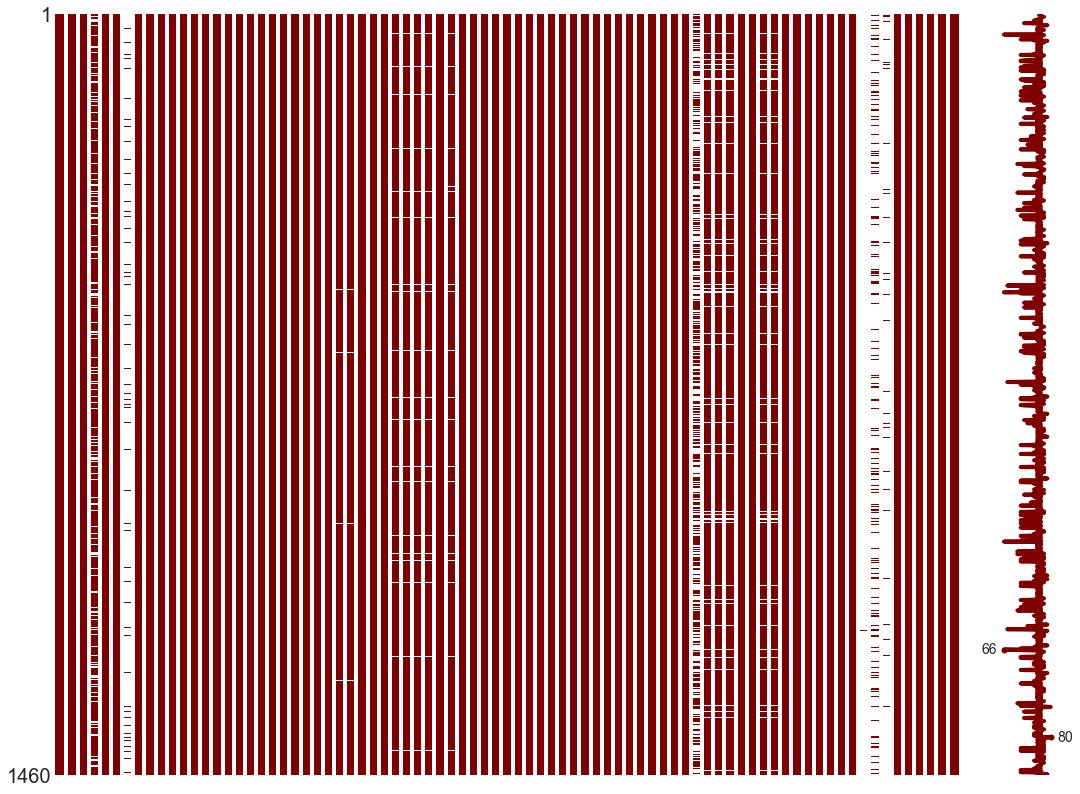

In [13]:
msno.matrix(df=train, figsize=(16, 14), color=(0.5,0,0))

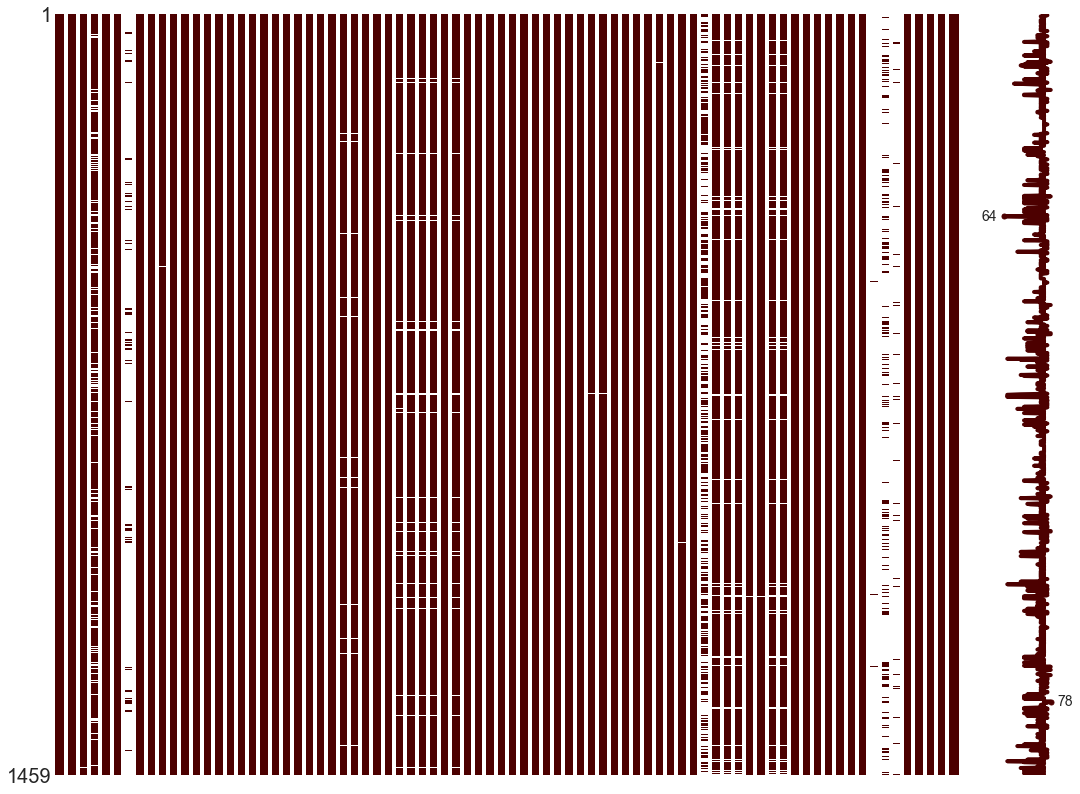

In [14]:
msno.matrix(df=test, figsize=(16, 14), color=(0.3,0,0))

# Features

In [15]:
# remove target from training features
features = test.columns.values.tolist()
print(len(features))
print(features)

80
['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'Pool

In [16]:
chk = column_checker(train, test, features)
chk

,features,is_categorical,overlap,train_nans,test_nans,train_nunique,test_nunique,train_min,test_min,train_max,test_max,train_mean,test_mean,train_skew,test_skew
0,Id,0,NaN,0,0,1460,1459,1.0,1461.0,1460.0,2919.0,730.500000,2190.000000,0.000000,0.000000
1,MSSubClass,0,NaN,0,0,15,16,20.0,20.0,190.0,190.0,56.897260,57.378341,1.407657,1.346690
2,MSZoning,1,1.200000,0,4,5,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,LotFrontage,0,NaN,259,227,110,115,21.0,21.0,313.0,200.0,70.049958,68.580357,2.163569,0.661921
4,LotArea,0,NaN,0,0,1073,1106,1300.0,1470.0,215245.0,56600.0,10516.828082,9819.161069,12.207688,3.115217
5,Street,1,1.000000,0,0,2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Alley,1,1.500000,1369,1352,2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,LotShape,1,1.000000,0,0,4,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,LandContour,1,1.000000,0,0,4,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,Utilities,1,1.500000,0,2,2,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


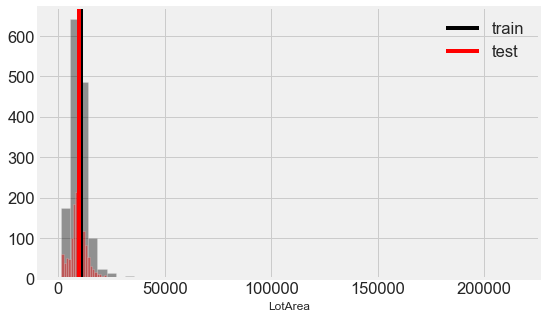

In [17]:
# histogram for a dense feature
plot_hist(train, test, "LotArea")

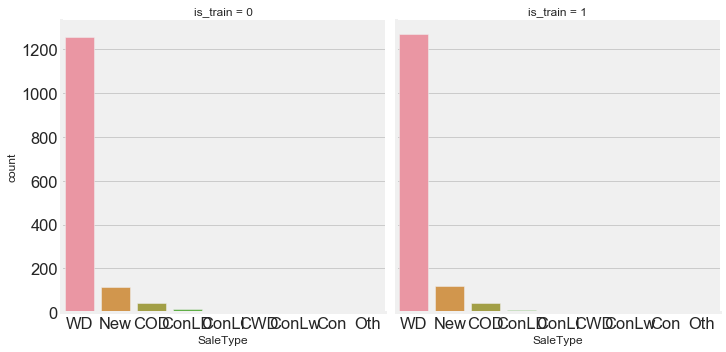

In [18]:
# count plot for a categorical feature
plot_count(train, test, "SaleType")

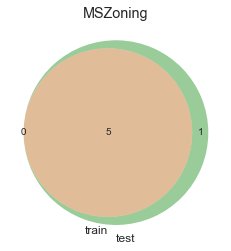

In [19]:
# venn
plot_venn(train, test, features[2])

## Feature Selection

### Categorical variables

In [20]:
# remove categorical variables which do not match btw. train & test
categoricals = chk.loc[(chk["is_categorical"] == 1) & (chk["overlap"] == 1), "features"].values.tolist()
print(len(categoricals))
print(categoricals)

20
['Street', 'LotShape', 'LandContour', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'ExterQual', 'ExterCond', 'Foundation', 'Heating', 'HeatingQC', 'CentralAir', 'PavedDrive', 'SaleCondition']


### Dense variables

In [21]:
dense_features = chk.loc[(chk["is_categorical"] == 0), "features"].values.tolist()
print(len(dense_features))
print(dense_features)

37
['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']


In [22]:
# preprocess
df = pd.concat([train, test], ignore_index=True)

# nan one hot
df, isnan_features = nan2onehot(df, dense_features)
        
# outlier remover
df = clipper(df, dense_features)
    
# to normal dist
# df = to_normal(df, dense_features)

# back to train, test
train = df.loc[:train.shape[0], :].reset_index(drop=True, inplace=False)
test = df.loc[train.shape[0]:, :].reset_index(drop=True, inplace=False)

In [23]:
# label encoding
for c in categoricals:
    le = LabelEncoder()
    le.fit(train[c].fillna("NA"))
    train[c] = le.transform(train[c].fillna("NA"))
    test[c] = le.transform(test[c].fillna("NA"))
    
categoricals = categoricals + isnan_features
print(len(categoricals))
print(categoricals)

22
['Street', 'LotShape', 'LandContour', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'ExterQual', 'ExterCond', 'Foundation', 'Heating', 'HeatingQC', 'CentralAir', 'PavedDrive', 'SaleCondition', 'LotFrontage_isnan', 'GarageYrBlt_isnan']


In [24]:
features = dense_features + categoricals
print(train[features].shape)
train[features].head()

(1461, 59)


,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,ExterQual,ExterCond,Foundation,Heating,HeatingQC,CentralAir,PavedDrive,SaleCondition,LotFrontage_isnan,GarageYrBlt_isnan
0,30.18,60,65.0,8450.0,7,5,2003,2003,196.0,706.0,...,2,4,2,1,0,1,2,4,0.0,0.0
1,30.18,20,80.0,9600.0,6,8,1976,1976,0.0,978.0,...,3,4,1,1,0,1,2,4,0.0,0.0
2,30.18,60,68.0,11250.0,7,5,2001,2002,162.0,486.0,...,2,4,2,1,0,1,2,4,0.0,0.0
3,30.18,70,60.0,9550.0,7,5,1915,1970,0.0,216.0,...,3,4,0,1,2,1,2,0,0.0,0.0
4,30.18,60,84.0,14260.0,8,5,2000,2000,350.0,655.0,...,2,4,2,1,0,1,2,4,0.0,0.0


In [25]:
print(test[features].shape)
test[features].head()

(1458, 59)


,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,ExterQual,ExterCond,Foundation,Heating,HeatingQC,CentralAir,PavedDrive,SaleCondition,LotFrontage_isnan,GarageYrBlt_isnan
0,1462.0,20,81.0,14267.0,6,6,1958,1958,108.0,923.0,...,3,4,1,1,4,1,2,4,0.0,0.0
1,1463.0,60,74.0,13830.0,5,5,1997,1998,0.0,791.0,...,3,4,2,1,2,1,2,4,0.0,0.0
2,1464.0,60,78.0,9978.0,6,6,1998,1998,20.0,602.0,...,3,4,2,1,0,1,2,4,0.0,0.0
3,1465.0,120,43.0,5005.0,8,5,1992,1992,0.0,263.0,...,2,4,2,1,0,1,2,4,0.0,0.0
4,1466.0,60,75.0,10000.0,6,5,1993,1994,0.0,0.0,...,3,4,2,1,2,1,2,4,0.0,0.0


# Feature importance

In [26]:
# LGB params
lgb_params = {"num_leaves": 45,
    "boosting_type": 'gbdt',
    "objective": 'regression',
    "metric": 'rmse',
    "max_depth": 7,
    "min_child_weight": 4,
    "feature_fraction": 0.52,
    "bagging_fraction": 0.97,
    "bagging_freq": 2,
    "min_child_samples": 27,
    "lambda_l1": 2.80368645398501e-06,
    "lambda_l2": 8.920589790760632e-06,
    "learning_rate": 0.07,
    "early_stopping_rounds": 300
    }

In [27]:
# LGB model
def fit_lgb(x_train, x_val, y_train, y_val, features, categoricals):
    verbosity = 100
    train_set = lgb.Dataset(x_train[features], y_train, categorical_feature=categoricals)
    val_set = lgb.Dataset(x_val[features], y_val, categorical_feature=categoricals)
    lgb_model = lgb.train(lgb_params, train_set, 1000, valid_sets=[train_set, val_set], verbose_eval=verbosity)
    fi = lgb_model.feature_importance(importance_type="gain")        
    return fi

# feature importance stored in data frame
def fi2df(fi, features=features):
    ranking = np.argsort(-fi)
    fi_df = pd.DataFrame()
    fi_df["features"] = np.array(features)[ranking]
    fi_df["importance_mean"] = fi[ranking]
    return fi_df

def plot_feature_importance(fi_df, rank_range=[1, 50]):
    # plot
    fig, ax = plt.subplots(1, 1, figsize=(10, 30))
    sns.barplot(x=fi_df.loc[:rank_range[1], "importance_mean"].values, y=fi_df.loc[:rank_range[1], "features"].values, orient='h', ax=ax)
    ax.set_xlabel("feature importance")
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False) 

In [28]:
kf = KFold(n_splits=3, random_state=1220, shuffle=True)
for fold, (tr_idx, va_idx) in enumerate(kf.split(train)):
    if fold == 0:
        x_train, x_val = train.loc[tr_idx, features], train.loc[va_idx, features]
        y_train, y_val = train.loc[tr_idx, target], train.loc[va_idx, target]

In [29]:
x_train.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,ExterQual,ExterCond,Foundation,Heating,HeatingQC,CentralAir,PavedDrive,SaleCondition,LotFrontage_isnan,GarageYrBlt_isnan
0,30.18,60,65.0,8450.0,7,5,2003,2003,196.0,706.0,...,2,4,2,1,0,1,2,4,0.0,0.0
1,30.18,20,80.0,9600.0,6,8,1976,1976,0.0,978.0,...,3,4,1,1,0,1,2,4,0.0,0.0
2,30.18,60,68.0,11250.0,7,5,2001,2002,162.0,486.0,...,2,4,2,1,0,1,2,4,0.0,0.0
3,30.18,70,60.0,9550.0,7,5,1915,1970,0.0,216.0,...,3,4,0,1,2,1,2,0,0.0,0.0
5,30.18,50,85.0,14115.0,5,5,1993,1995,0.0,732.0,...,3,4,5,1,0,1,2,4,0.0,0.0


In [30]:
# fit LGB
fi = fit_lgb(x_train, x_val, y_train, y_val, features, categoricals)

Training until validation scores don't improve for 300 rounds
[100]	training's rmse: 15048.6	valid_1's rmse: 34251.6
[200]	training's rmse: 10755.2	valid_1's rmse: 33542
[300]	training's rmse: 8261.96	valid_1's rmse: 33441.4
[400]	training's rmse: 6734.7	valid_1's rmse: 33540.7
[500]	training's rmse: 5559.1	valid_1's rmse: 33593.9
Early stopping, best iteration is:
[280]	training's rmse: 8696.16	valid_1's rmse: 33423.7


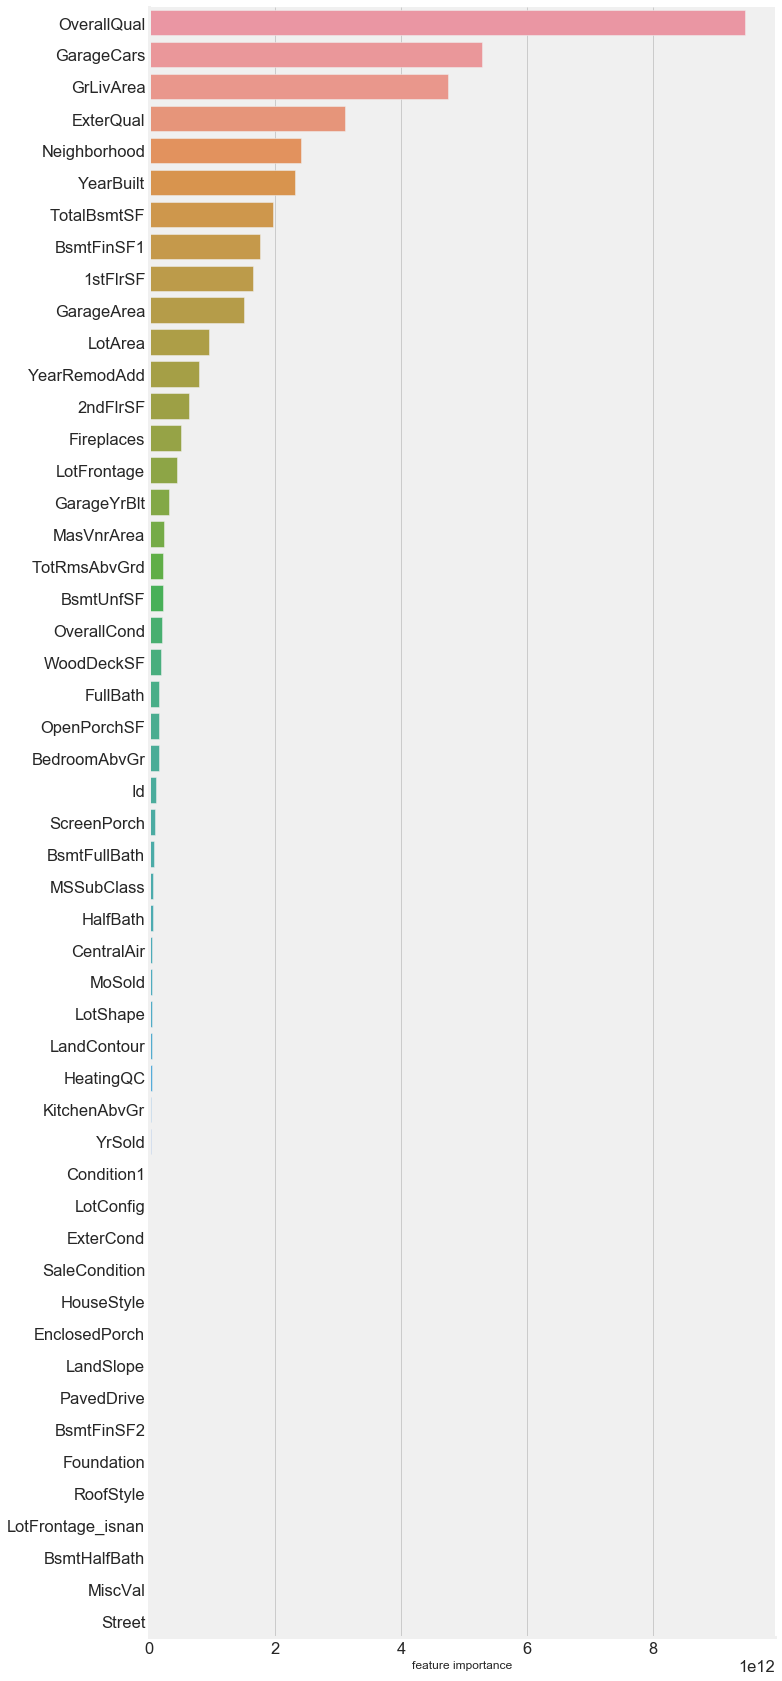

In [31]:
fi_df = fi2df(fi, features)
plot_feature_importance(fi_df, rank_range=[1, 50])